In [1]:
### 导入模块
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import shap
import numpy as np
#预测
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
def performance_clf(model, X, y, metrics_name=None):
    y_pred = model.predict(X)
    if metrics_name:
        print(metrics_name, ":")
    print(f'accuracy score is : {accuracy_score(y, y_pred)}')
    print(f'precision score is : {precision_score(y, y_pred)}')
    print(f'recall score is : {recall_score(y, y_pred)}')
    print(f'auc score is : {roc_auc_score(y, y_pred)}')
    print(f'f1 score is : {f1_score(y, y_pred)}')
    print("----------------------------")

In [2]:
train_features = np.load("train_features.npy")
train_label = np.load("train_label.npy")
test_features = np.load("test_features.npy")
test_label = np.load("test_label.npy")

train_data = np.append(train_features, train_label.reshape(-1,1), axis = 1)
test_data = np.append(test_features, test_label.reshape(-1,1), axis = 1)
data = np.append(train_data, test_data, axis = 0)

In [3]:
column_names = ([f'DF{i+1}' for i in range(8)])
column_names.extend(["NCE","MRD","MCD","MBD","NCEE","M2DD","M3DD","NA16","NA64","NA144"])
column_names.extend([f'DF{i+1}' for i in range(8,16)])

print(len(column_names))
print(column_names)

26
['DF1', 'DF2', 'DF3', 'DF4', 'DF5', 'DF6', 'DF7', 'DF8', 'NCE', 'MRD', 'MCD', 'MBD', 'NCEE', 'M2DD', 'M3DD', 'NA16', 'NA64', 'NA144', 'DF9', 'DF10', 'DF11', 'DF12', 'DF13', 'DF14', 'DF15', 'DF16']


In [4]:
column_names.append("label")
# 转换为 DataFrame，并添加列名
df = pd.DataFrame(data, columns=column_names)

In [5]:
# 数据
data = df

# 处理
data = data.dropna()
X = data.drop(['label'], axis=1)
y = data['label']

In [6]:
# 划分训练集和测试集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=2021, shuffle=True)

In [7]:
### 创建模型
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                            booster='gbtree',
                            n_estimators=284,
                            max_depth=10,
                            reg_alpha=0.071,
                            min_child_weight=0.217,
                            colsample_bynode=0.265,
                            subsample=0.268,
                            learning_rate=0.062,
                            use_label_encoder=False,
                            scale_pos_weight=0.463
                            )

# xgb训练
xgb_clf = xgb_clf.fit(x_train, y_train)
print("-----XGBOOST----")
performance_clf(xgb_clf, x_train, y_train, metrics_name='train')
performance_clf(xgb_clf, x_test, y_test, metrics_name='test')

-----XGBOOST----
train :
accuracy score is : 0.8806594488188977
precision score is : 0.9626556016597511
recall score is : 0.793743890518084
auc score is : 0.881262430888378
f1 score is : 0.8700776855076348
----------------------------
test :
accuracy score is : 0.7009345794392523
precision score is : 0.6746987951807228
recall score is : 0.6021505376344086
auc score is : 0.68950502088332
f1 score is : 0.6363636363636364
----------------------------


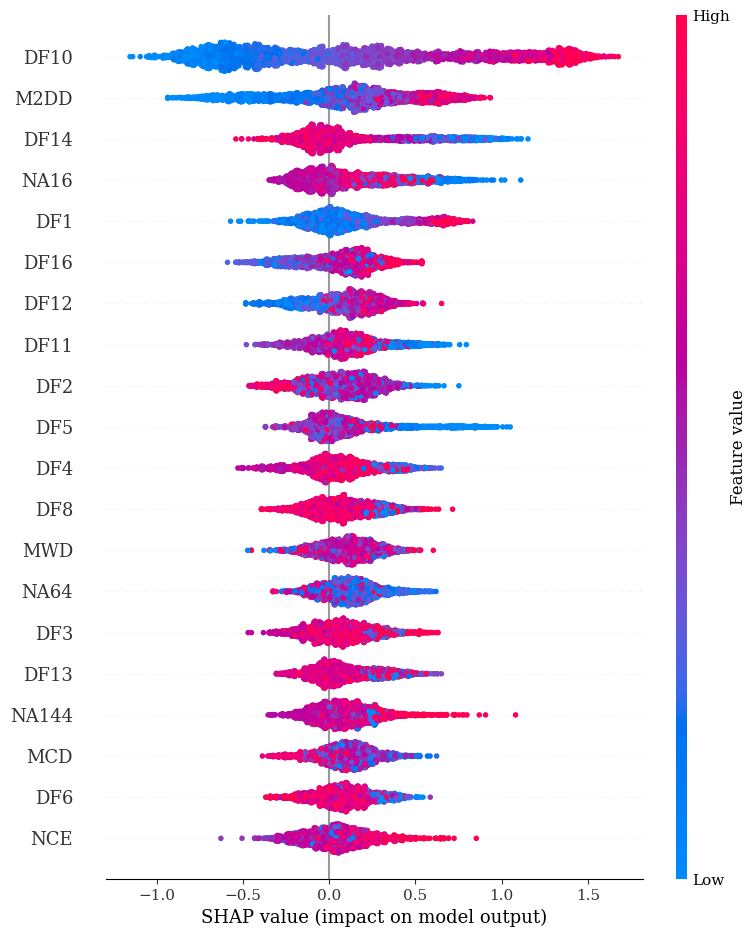

In [18]:
# SHAP分析
column_names = ["DF1","DF2","DF10","DF11","DF12","DF16","NA16","NCE","DF14","DF15","M2DD",
                "DF6","MHD","DF4","DF5","DF7","DF8","DF9","MWD","NA64","DF3","MCD","NCEE","M3DD","NA144","DF13"]
x_train.columns = column_names
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(x_train)
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
shap.initjs()

# import pandas as pd
# shap_df = pd.DataFrame(shap_values, columns=x_test.columns)
# shap_df.to_csv('shap_values.csv', index=False)
####总体分析
shap.summary_plot(shap_values, x_train)

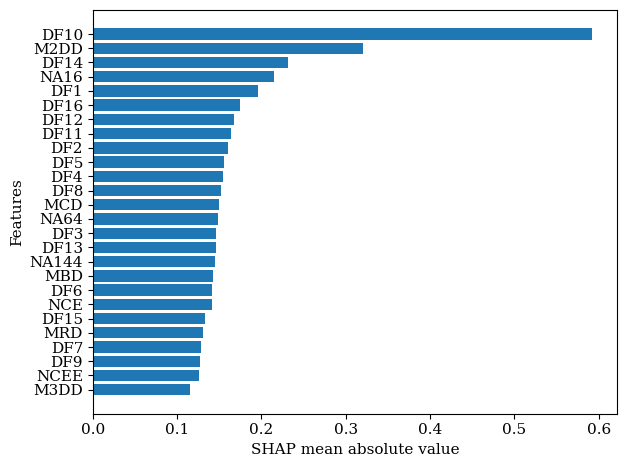

In [16]:
##shap平均影响排序图
import numpy as np
abs_shap_values = np.abs(shap_values)
mean_abs_shap_values = np.mean(abs_shap_values, axis=0)
sorted_indices = np.argsort(mean_abs_shap_values)
sorted_features = x_train.columns[sorted_indices]
sorted_mean_abs_shap_values = mean_abs_shap_values[sorted_indices]
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 11  # 设置全局字体大小
# plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_mean_abs_shap_values, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('SHAP mean absolute value')
plt.ylabel('Features')
# plt.title('SHAP平均影响排序图')
plt.tight_layout()
plt.show()